# EDA1

In [1]:
# base
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

#显示所有列
#pd.set_option('display.max_columns', None)
#显示所有行
#pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
#pd.set_option('max_colwidth',100)
#np.set_printoptions(threshold=np.inf)

/Users/helloword/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# 减小内存用量
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def load_data():
    train = pd.read_csv('./data/train.csv')
    train = reduce_mem_usage(train)
    test = pd.read_csv('./data/test.csv')
    test = reduce_mem_usage(test)
    return train ,test
train,test = load_data()

Memory usage of dataframe is 308.23 MB --> 154.30 MB (Decreased by 49.9%)
Memory usage of dataframe is 306.70 MB --> 154.11 MB (Decreased by 49.8%)


In [4]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679973,-1.627628,10.715126,6.796523,11.078255,-5.065340,5.408961,16.545988,0.284159,...,3.234436,7.438449,1.927833,3.331773,17.993811,-0.142087,2.303355,8.908224,15.870864,-3.326542
std,0.300653,3.039990,4.049967,2.640832,2.043276,1.623114,7.863115,0.866585,3.418009,3.332576,...,4.559854,3.023208,1.478388,3.991934,3.135113,1.429341,5.454274,0.921603,3.010892,10.437832
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562599,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852798
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064724,4.836800
max,1.000000,20.315001,10.376800,19.353001,13.188300,16.671400,17.251600,8.447700,27.691799,10.151300,...,18.440901,16.716499,8.402400,18.281799,27.928801,4.272900,18.321501,12.000400,26.079100,28.500700


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), int8(1), object(1)
memory usage: 154.3+ MB


# 查看缺失值

In [6]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return (np.transpose(tt))

missing_data(train)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int8,float32,float32,float32,float32,float32,float32,float32,float32,...,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32


# 画出训练机和测试集之间的特征分布 x轴是训练集的值，y轴是测试集的值

<Figure size 432x288 with 0 Axes>

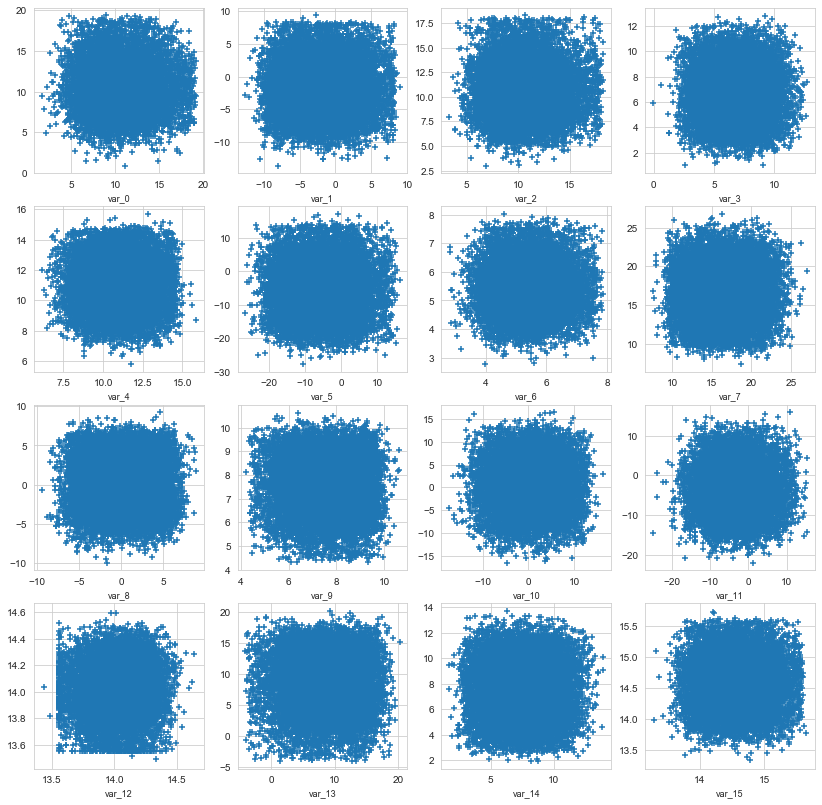

In [7]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4 , 4 , figsize=(14 , 14))

    for feature in features:
        i += 1
        plt.subplot(4 ,4 ,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show()
    
features = [
    'var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
    'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
]
plot_feature_scatter(train[::20],test[::20], features)

# 查看分类类别的比例

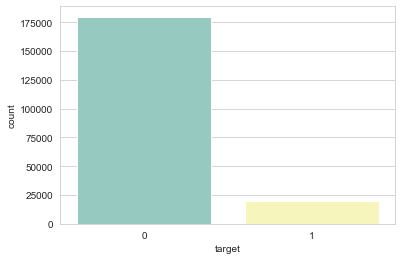

In [8]:
# 查看分类类别的分布
sns.countplot(train['target'], palette='Set3')

# 数据不均衡

In [9]:
print("There are {}% target values with 1".format(100 * train["target"].value_counts()[1]/train.shape[0]))
# 数据不均衡

There are 10.049% target values with 1


# 绘制 表示 1 和 0 的特征分布

In [10]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10 , 10 ,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label = label1)
        sns.distplot(df2[feature], hist=False,label = label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

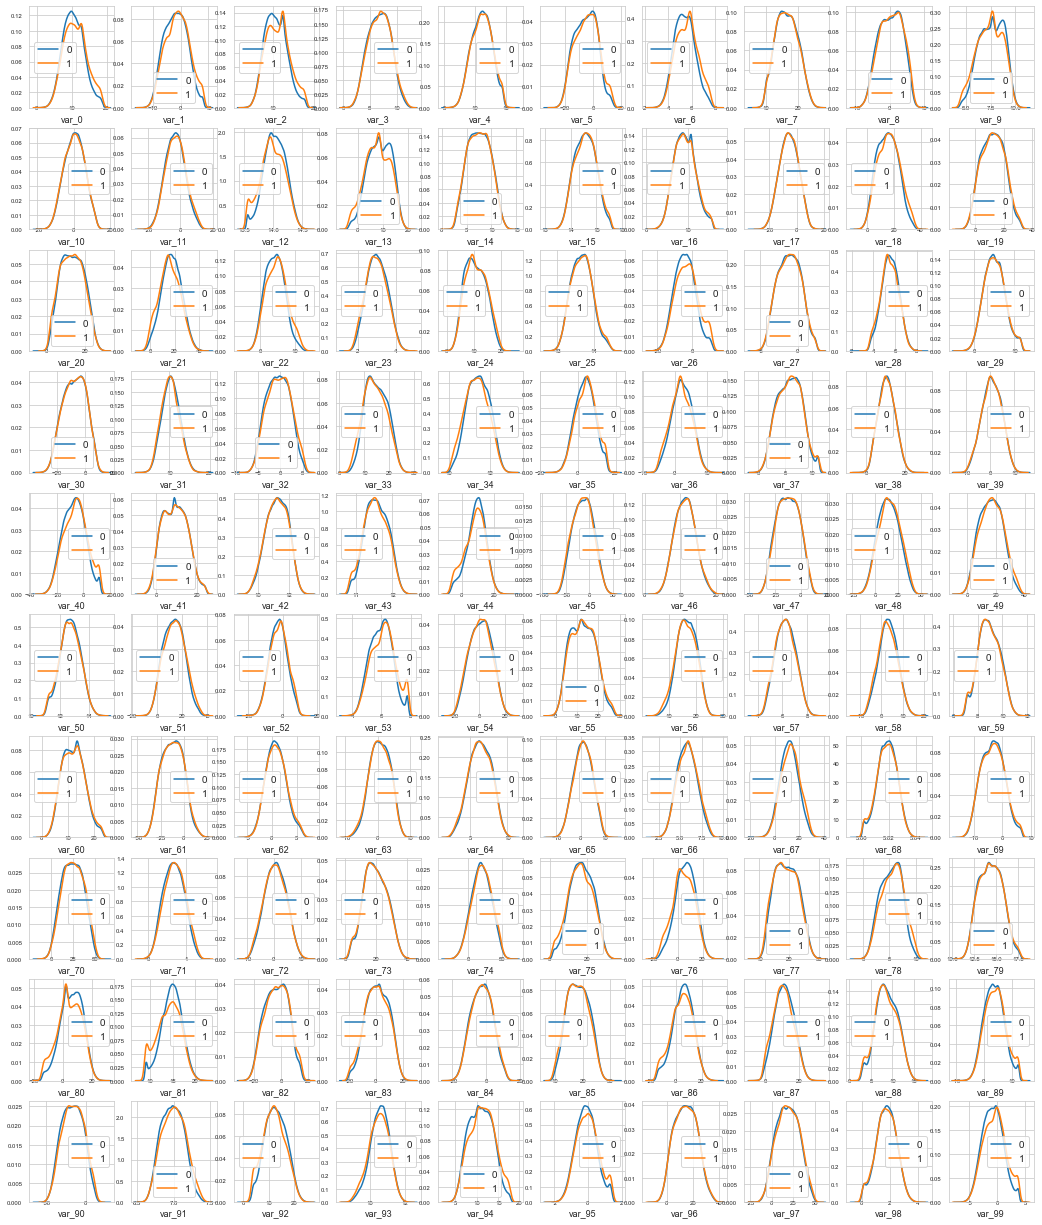

In [11]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]

features = train.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

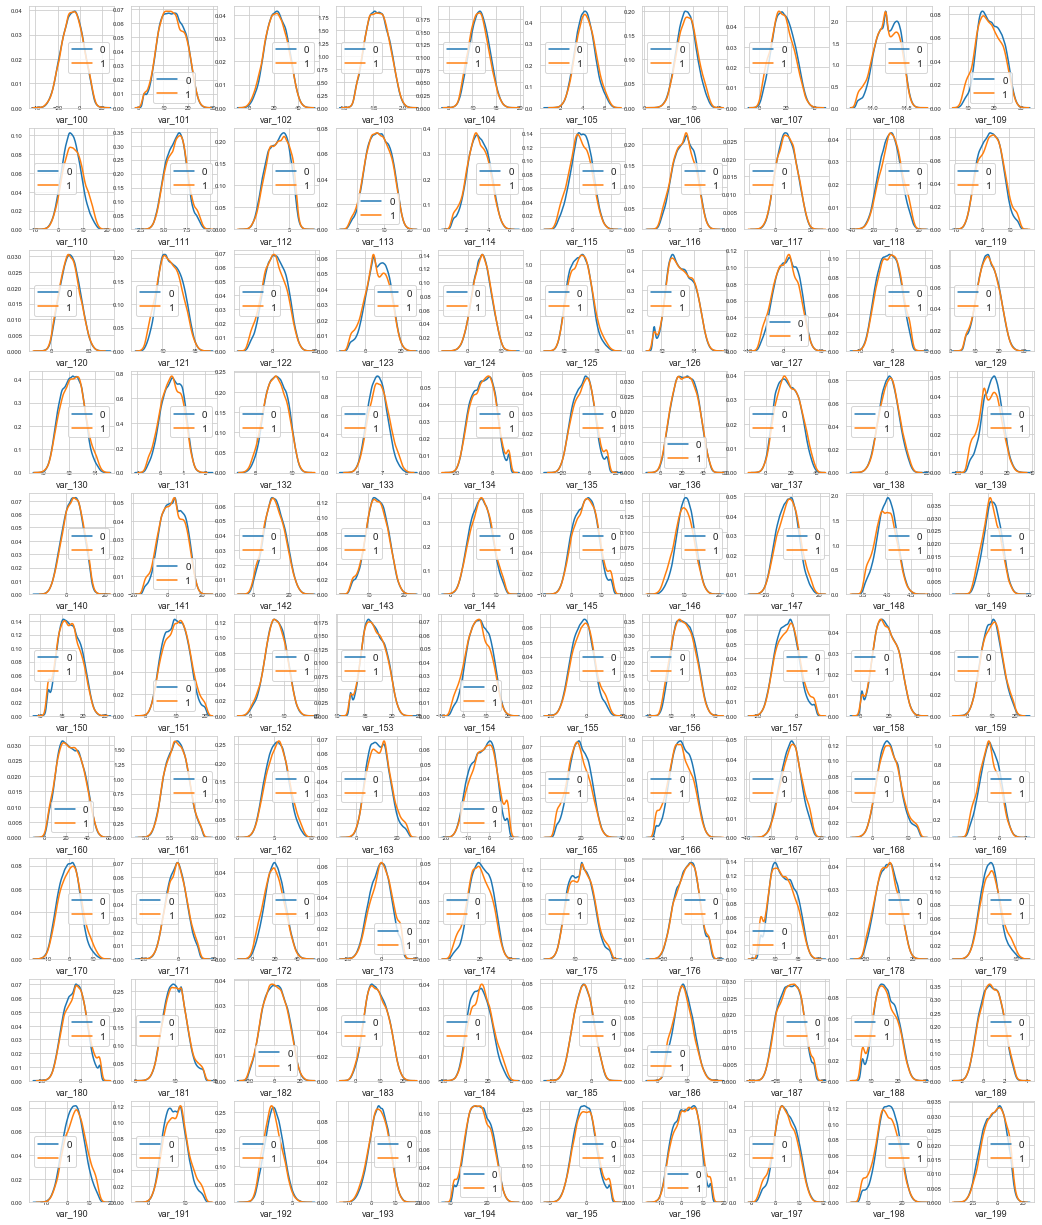

In [12]:
features = train.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

# 绘制训练集和测试集的特征分布情况

<Figure size 432x288 with 0 Axes>

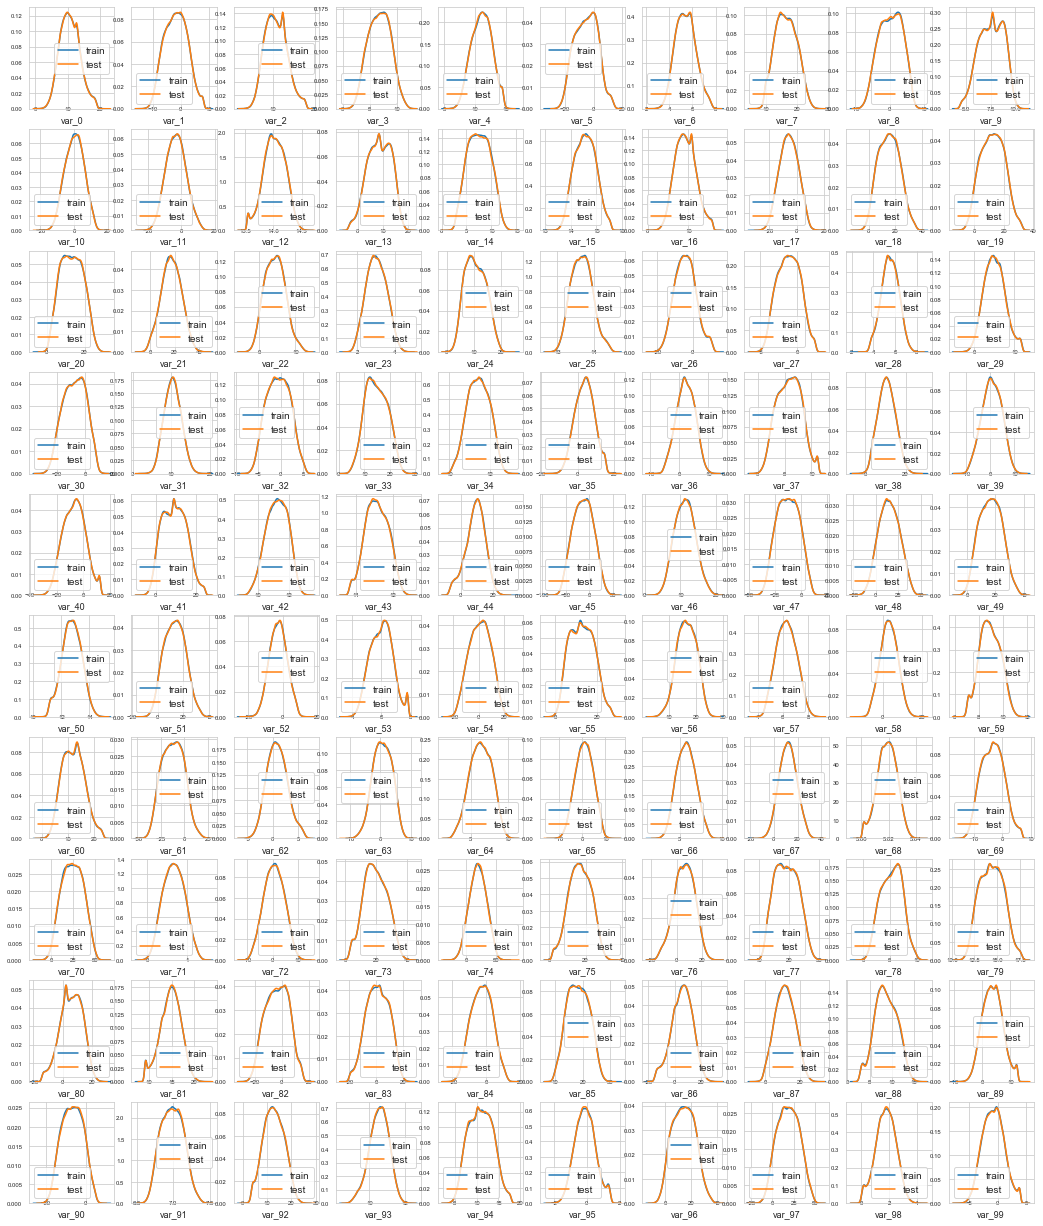

In [13]:
# 看看特征值的分布在测试集和训练集合中的分布情况 2:102
features = train.columns.values[2:102]
plot_feature_distribution(train, test, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

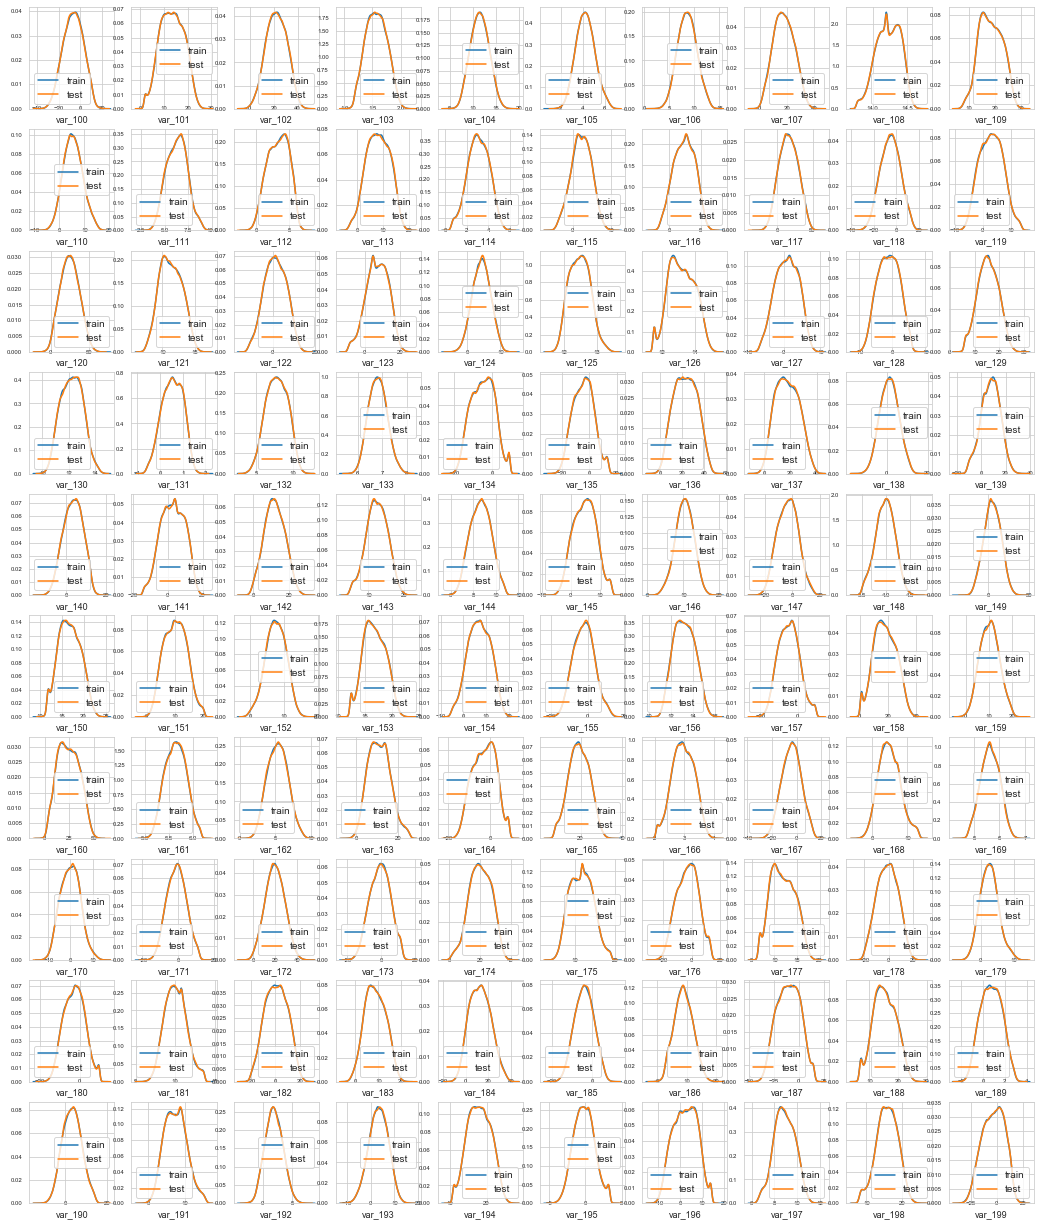

In [14]:
# 看看特征值的分布在测试集和训练集合中的分布情况 102:202
features = train.columns.values[102:202]
plot_feature_distribution(train, test, 'train', 'test', features)

# 在train 和 test 集合中的每个样本的平均值分布

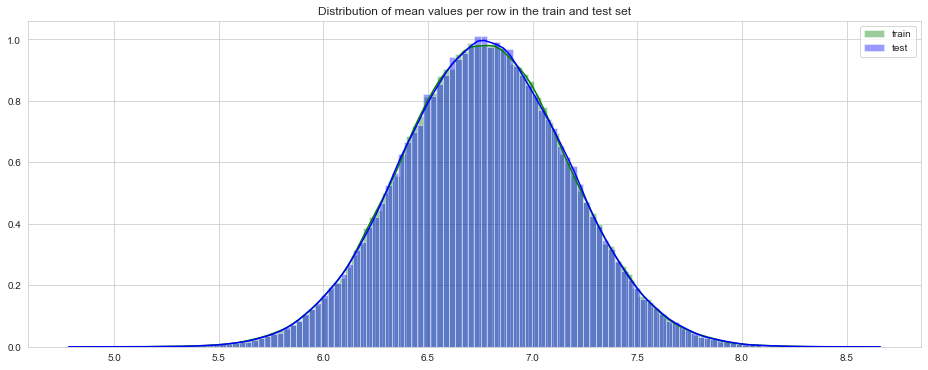

In [15]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1) ,color="green", kde=True ,bins=120 ,label='train')
sns.distplot(test[features].mean(axis=1) ,color="blue", kde=True ,bins=120 ,label='test')
plt.legend()
plt.show()

# 绘制每个特征的平均值的分布

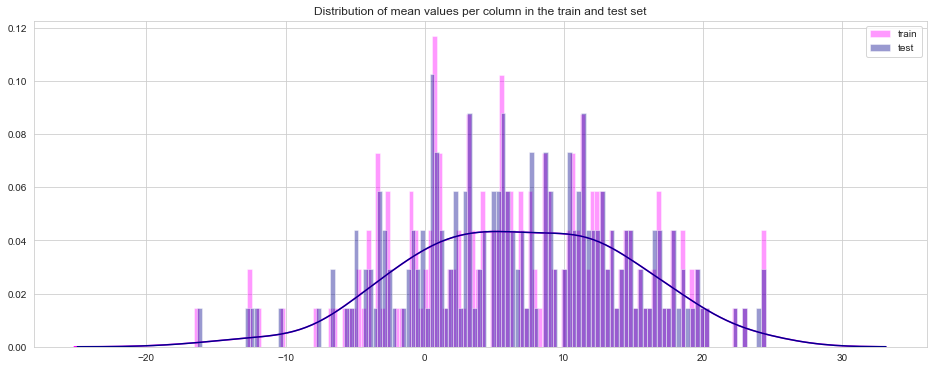

In [16]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0) , color="magenta", kde=True, bins=120, label='train')
sns.distplot(test[features].mean(axis=0) , color="darkblue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

# 样本的标准差分布

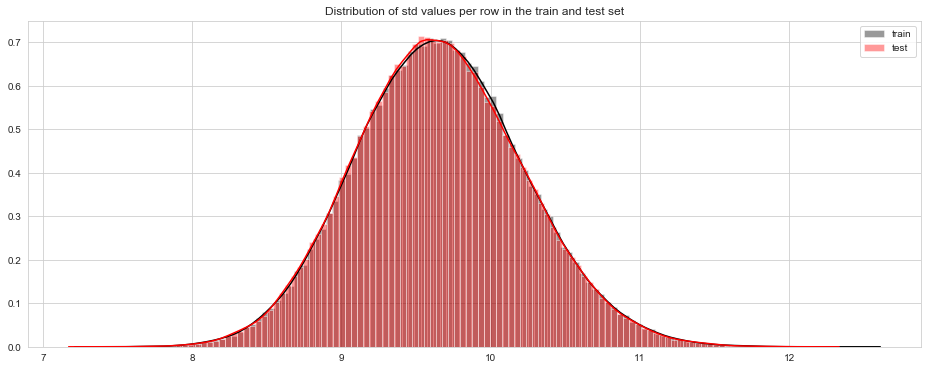

In [17]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True, bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True, bins=120, label='test')
plt.legend();plt.show()

# 特征的标准差分布

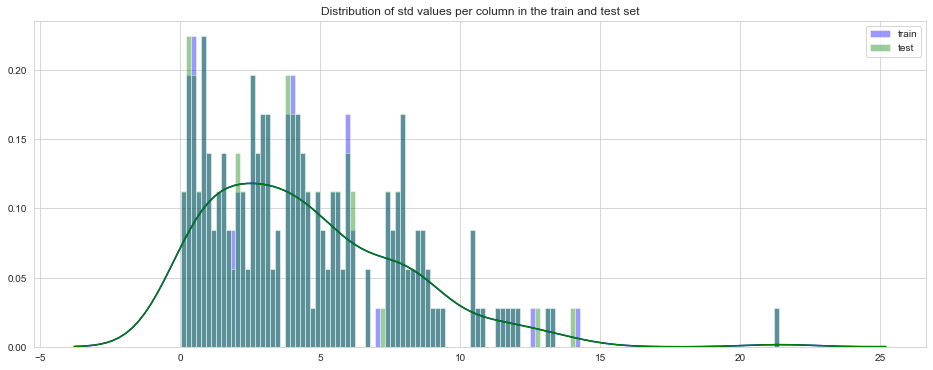

In [18]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

# 分类类别为1和0的样本均值分布

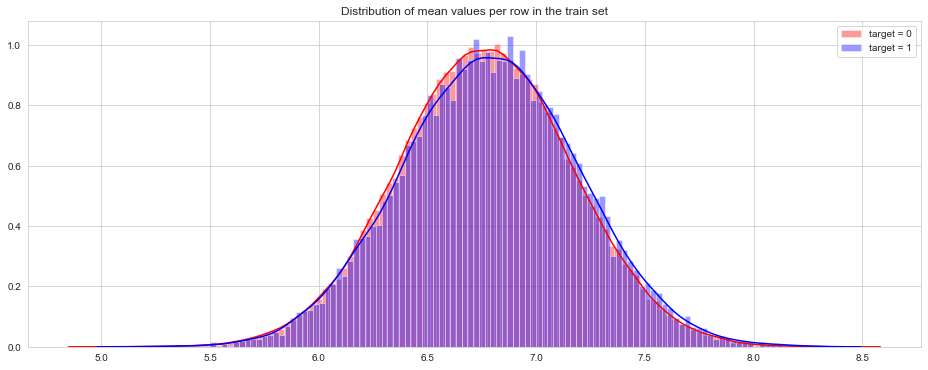

In [19]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1), color="red", kde=True ,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1), color="blue", kde=True ,bins=120, label='target = 1')
plt.legend()
plt.show()

# 分类类别为0和1的特征的均值分布

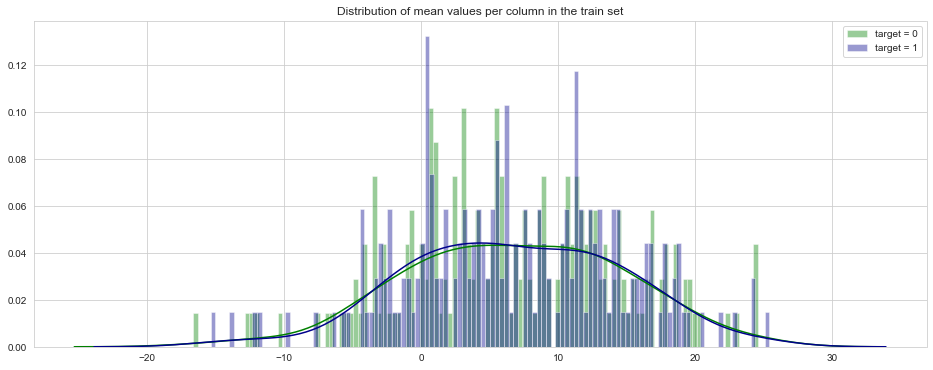

In [20]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0) ,color="green" ,kde=True ,bins=120 ,label='target = 0')
sns.distplot(t1[features].mean(axis=0) ,color="darkblue" ,kde=True ,bins=120 ,label='target = 1')
plt.legend()
plt.show()

# 样本最小值的分布

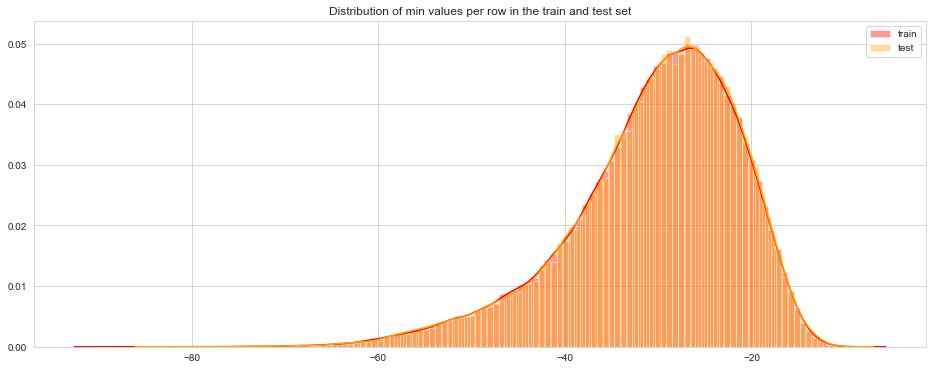

In [21]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

# 特征的最小值分布

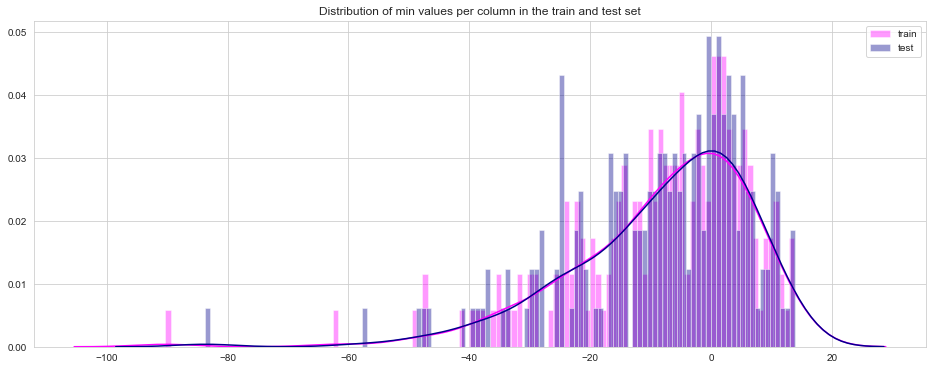

In [22]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train[features].min(axis=0) ,color="magenta", kde=True ,bins=120, label='train')
sns.distplot(test[features].min(axis=0) ,color="darkblue", kde=True ,bins=120, label='test')
plt.legend()
plt.show()

# 样本的最大值的分布

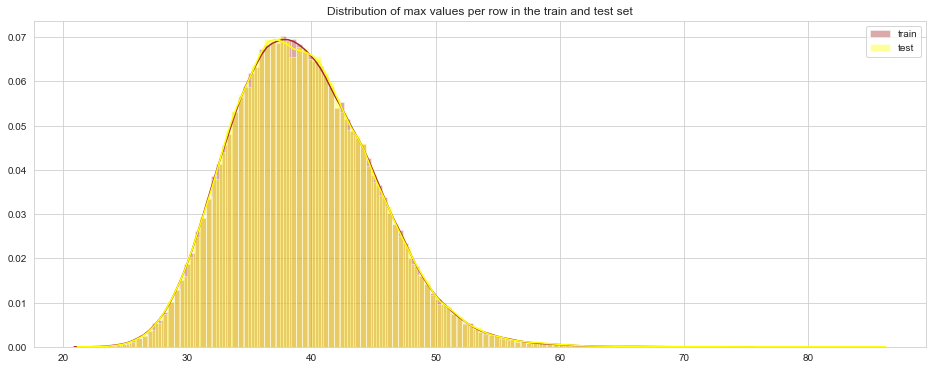

In [23]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

# 特征的最大值的分布

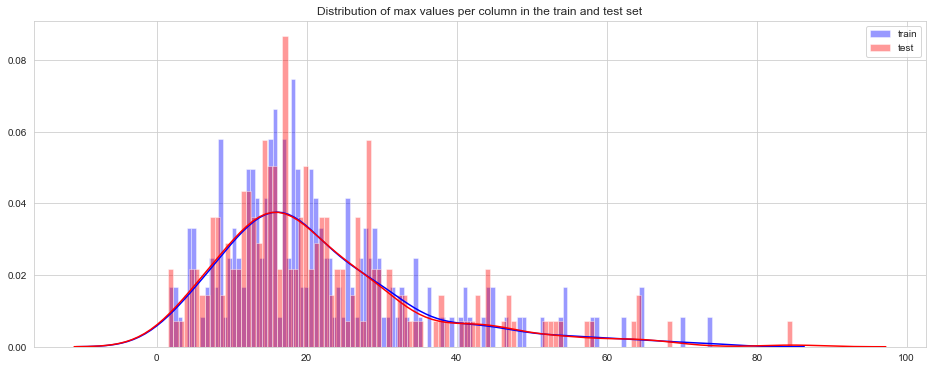

In [24]:
plt.figure(figsize=(16,6))
features = train.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train[features].max(axis=0) ,color="blue", kde=True ,bins=120, label='train')
sns.distplot(test[features].max(axis=0) ,color="red", kde=True ,bins=120, label='test')
plt.legend()
plt.show()

# 以分类类别 0 ，1 绘制样本最小值

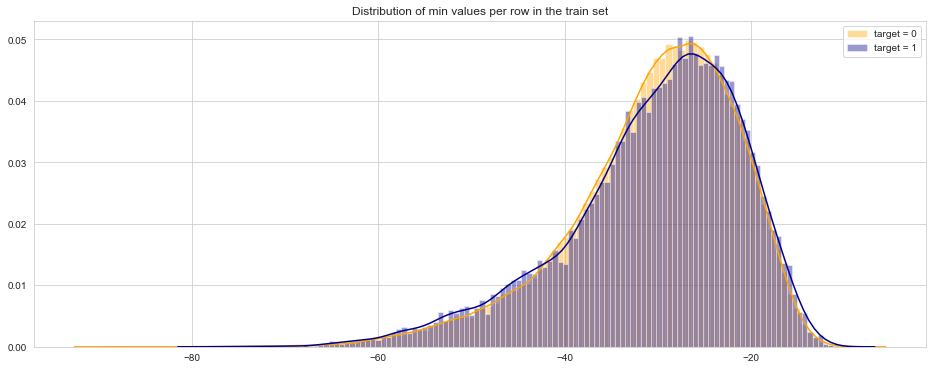

In [25]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True ,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True ,bins=120, label='target = 1')
plt.legend()
plt.show()

# 以分类类别 0 , 1 绘制特征最小值

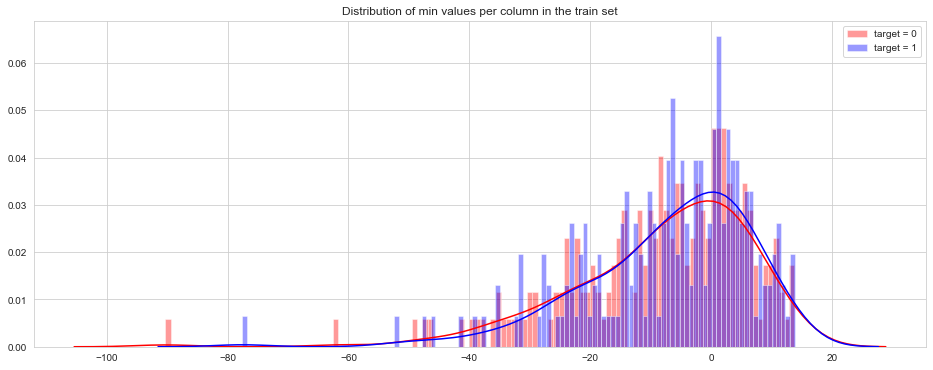

In [26]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0) ,color="red", kde=True ,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0) ,color="blue", kde=True ,bins=120, label='target = 1')
plt.legend()
plt.show()

# 样本最大值的分布

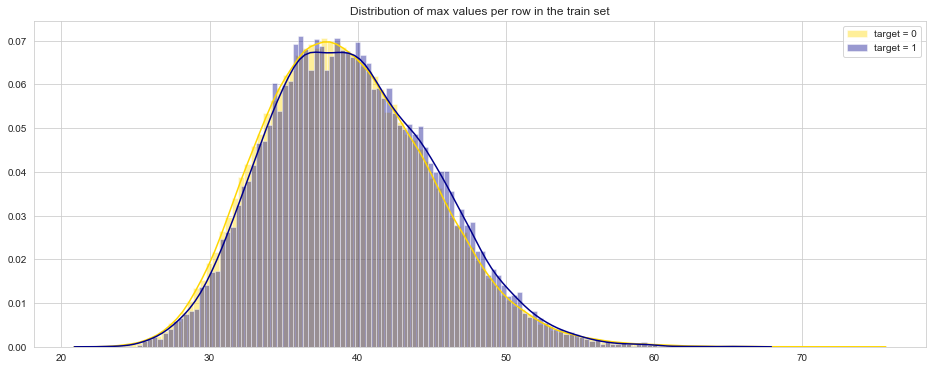

In [27]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

# 特征最大值的分布

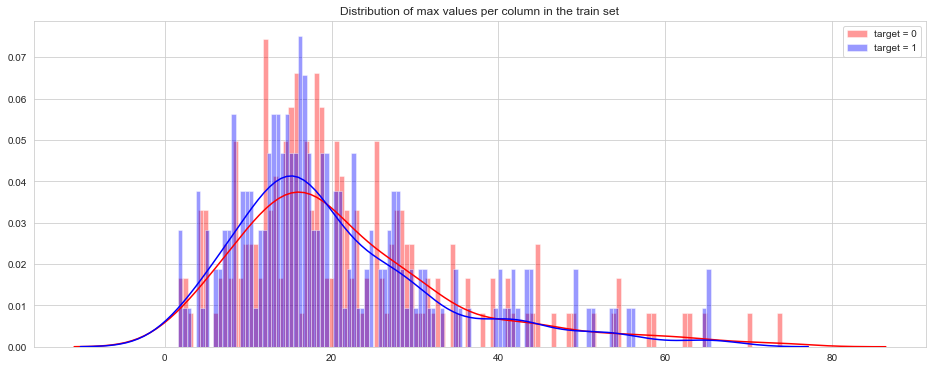

In [28]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

# 样本的偏斜度

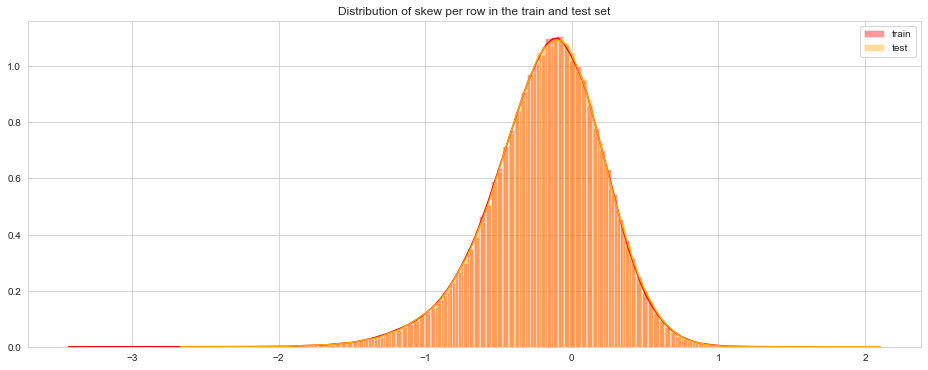

In [29]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

# 特征的偏斜度

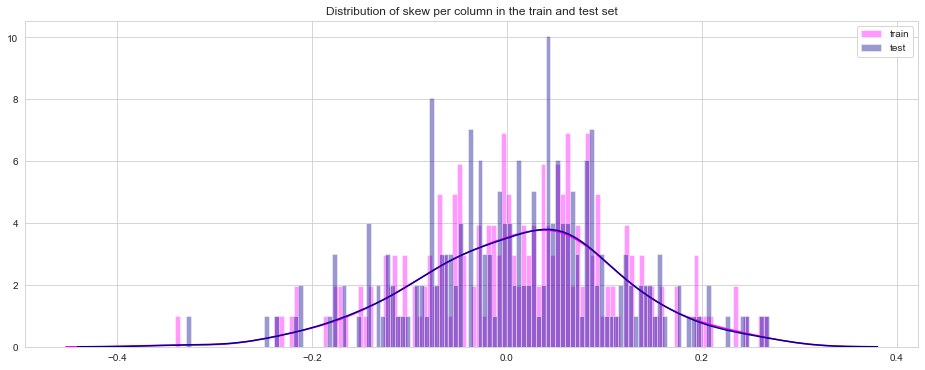

In [30]:
fig = plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train[features].skew(axis=0) ,color="magenta" ,kde=True ,bins=120 ,label='train')
sns.distplot(test[features].skew(axis=0) ,color="darkblue" ,kde=True ,bins=120 ,label='test')
plt.legend()
plt.show()

# 样本的峰度

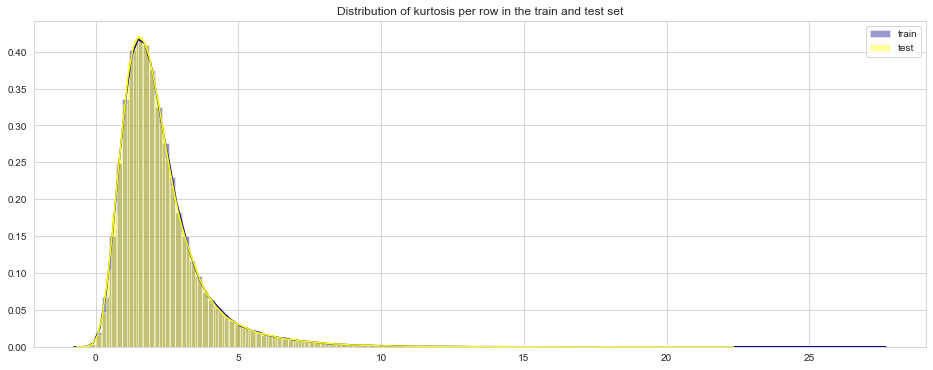

In [31]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train[features].kurtosis(axis=1) ,color="darkblue" ,kde=True ,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=1) ,color="yellow" ,kde=True ,bins=120, label='test')
plt.legend()
plt.show()

# 特征的分布

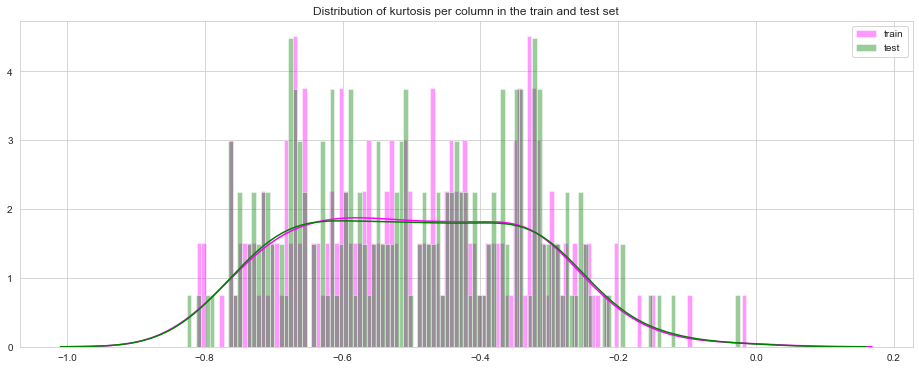

In [32]:
plt.figure(figsize=(16 , 6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train[features].kurtosis(axis=0) ,color="magenta", kde=True ,bins=120, label='train')
sns.distplot(test[features].kurtosis(axis=0) ,color="green", kde=True ,bins=120, label='test')
plt.legend()
plt.show()

# 分类类别为 0 1 样本的偏斜度

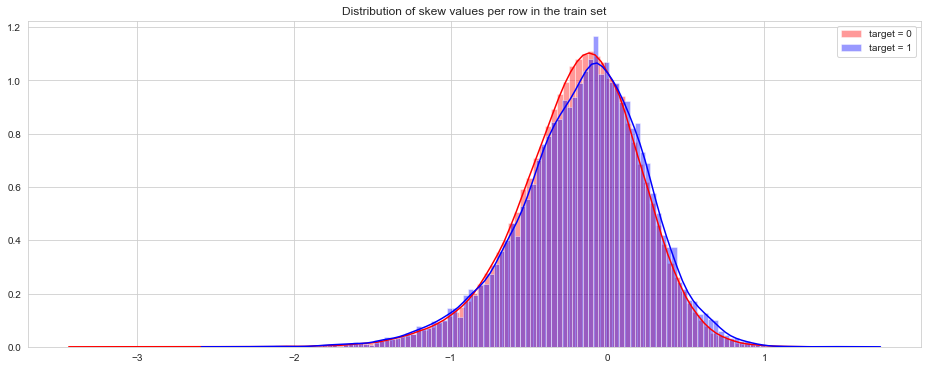

In [33]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16 , 6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

# 分类类别为 0 1 的特征的斜度分布

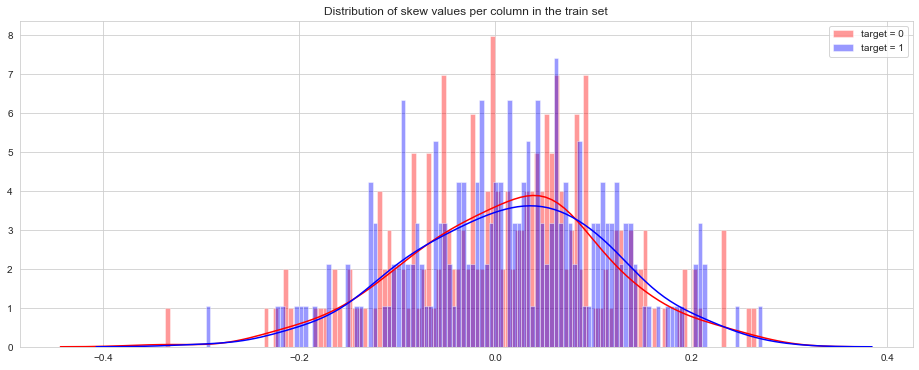

In [34]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0), color="red", kde=True, bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0), color="blue", kde=True, bins=120, label='target = 1')
plt.legend()
plt.show()

# 分类类别为0 1 的样本的峰度分布

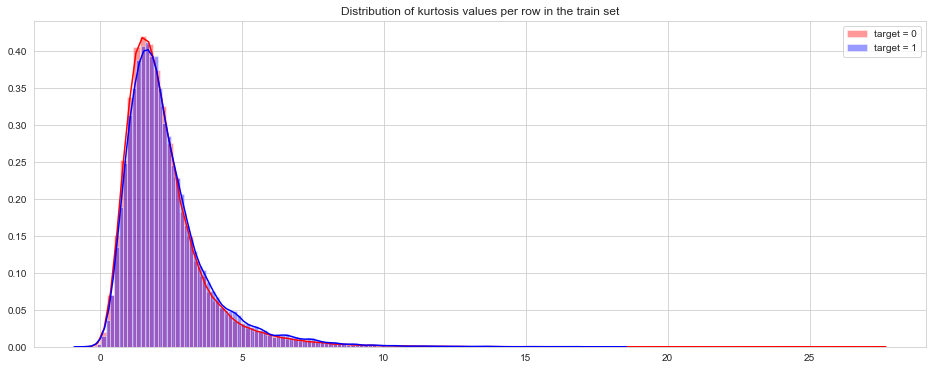

In [36]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

# 分类类别为0 1 的特征的峰度分布

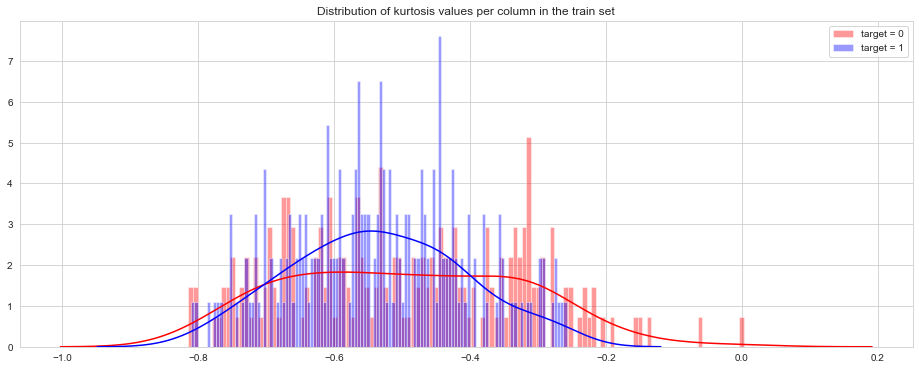

In [38]:
t0 = train.loc[train['target'] == 0]
t1 = train.loc[train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

# 特征相关性

In [41]:
%%time
correlations = train[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

CPU times: user 13.7 s, sys: 279 ms, total: 14 s
Wall time: 14.5 s


,level_0,level_1,0
0,var_75,var_191,2.675365e-08
1,var_191,var_75,2.675365e-08
2,var_173,var_6,5.886845e-08
3,var_6,var_173,5.886845e-08
4,var_126,var_109,1.326374e-07
5,var_109,var_126,1.326374e-07
6,var_144,var_27,1.769831e-07
7,var_27,var_144,1.769831e-07
8,var_177,var_100,3.114128e-07
9,var_100,var_177,3.114128e-07


In [42]:
correlations.head(10)

,level_0,level_1,0
0,var_75,var_191,2.675365e-08
1,var_191,var_75,2.675365e-08
2,var_173,var_6,5.886845e-08
3,var_6,var_173,5.886845e-08
4,var_126,var_109,1.326374e-07
5,var_109,var_126,1.326374e-07
6,var_144,var_27,1.769831e-07
7,var_27,var_144,1.769831e-07
8,var_177,var_100,3.114128e-07
9,var_100,var_177,3.114128e-07


# 可以看出特征与特征之间的相关性很低